In [49]:
import sys
import os
import ruamel.yaml as yaml
sys.path.append("~/Repositories/surrDAMH")
from surrDAMH.modules import visualization_and_analysis as va
from surrDAMH.modules import analysis as ape
import matplotlib.pyplot as plt
import numpy as np

## Obligatory paths

In [50]:
conf_path = "config_mcmc_bayes.yaml"
path_to_data = "./saved_samples2"

# načtení dat a formatovani dat

In [51]:
### PREPARATION:
basename = os.path.basename(conf_path)
problem_name, fext = os.path.splitext(basename)

output_dir = os.path.join(path_to_data, problem_name)

with open(conf_path) as f:
    conf = yaml.safe_load(f)


observations = np.array(conf["problem_parameters"]["observations"])
no_parameters = conf["no_parameters"]

### LOAD DATA:
raw_data = ape.RawData()
raw_data.load(output_dir, no_parameters, len(observations))

raw data: no_stages 2
raw data: no_chains 19
raw data: no_samples 495114
raw data: no_nonconverging 0
raw data: p (495114, 8)
raw data: w (495114, 1)
raw_data: np.sum(weights): 490146


## Filtrovaní dat

In [52]:
# type: 0-accepted, 1-prerejected, 2-rejected
no_stages = len(conf["samplers_list"])
raw_data_filtered = raw_data.filter(types=[0,2], stages=range(no_stages+1))
# raw_data_accepted = raw_data.filter(types=[0], stages=range(0,no_stages+1))


filter raw data: p (24844, 8)


## Rekonstrukce modelu šumu pro výpočet likelihoodu

In [53]:
import surrDAMH.modules.Gaussian_process as gp

def compute_log_likelihood_all(data):
    # reconstruct covariance of the noise
    cov_mat = gp.assemble_covariance_matrix(conf['noise_model'])

    # rewritten likelihood for our model
    def get_log_likelihood_multivariate(observations, G_sample,noise_std):
        v = observations - G_sample.ravel()
        invCv = np.linalg.solve(noise_std,v)
        return -0.5*np.dot(v,invCv)

    # measurement from conf
    y_orig = np.array(conf['problem_parameters']['observations'])

    log_likelihood = np.zeros((data.shape[0],1))
    for idx,obs in enumerate(data):
        log_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)
    
    return log_likelihood

## Transformace observation na normované hodnoty

In [54]:
n_filt = raw_data_filtered.observations.shape[0]
m_filt = raw_data_filtered.observations.shape[1]
k_filt = raw_data_filtered.parameters.shape[1]

# transform data according to conf['transformations']
parameters_transformed_filt = raw_data_filtered.parameters.copy()

for i in range(parameters_transformed_filt.shape[1]):
    parameters_transformed_filt[:,i] =  (np.log(raw_data_filtered.parameters[:,i]) - conf['transformations'][i]['options']['mu'])/conf['transformations'][i]['options']['sigma']

raw_data_filtered.parameters = parameters_transformed_filt

## Vytvoření datasetu pro trénování a testování

In [85]:
data = raw_data_filtered.parameters
obs = raw_data_filtered.observations

obs_likelihood = compute_log_likelihood_all(obs)

# filter only data and obs with obs_likelihood > -10
data = data[obs_likelihood.ravel() > -1, :]
obs = obs[obs_likelihood.ravel() > -1, :]

from sklearn.model_selection import train_test_split

input_data = data
output_data = obs

# rozdělit data na trénovací a testovací set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.9, random_state=42)

likelihood_train = compute_log_likelihood_all(y_train)
likelihood_test = compute_log_likelihood_all(y_test)
likelihood_train.shape

(42, 1)

In [62]:
## vytvoření datasetu pomocí class Snapshot pro surrogaty ze surrDAMH
from surrDAMH.modules.classes_SAMPLER import Snapshot
# create a list of snapshots
snapshots = []

for i in range(X_train.shape[0]):
    snapshots.append(Snapshot(X_train[i,:], y_train[i,:], weight=1.0))


# create a list of snapshots of likelihood only
snapshots_likelihood = []

for i in range(X_train.shape[0]):
    snapshots_likelihood.append(Snapshot(X_train[i,:], likelihood_train[i,:], weight=1.0))

k = X_train.shape[1]
m = y_train.shape[1]

In [73]:
# simulace acceptance probability

def acceptance_prob_all(prediction_likelihood):
    # create random permutation of filt_likelihood,acc_likelihood
    idx = np.random.permutation(len(prediction_likelihood))
    old_pred = prediction_likelihood[idx]
    old_test = likelihood_test[idx]

    alpha_s = np.minimum(likelihood_test + old_pred - prediction_likelihood - old_test,0)

    return np.exp(alpha_s)

In [74]:
def plot_results_only_likelihood(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # First subplot
    axs[0].scatter(likelihood_test, res_surr, alpha=0.1, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)

    # Second subplot
    alpha_all = acceptance_prob_all(res_surr)
    axs[1].hist(alpha_all)
    mean_acceptance = np.mean(alpha_all)
    axs[1].set_title(f'mean acceptance = {mean_acceptance}')
    plt.show()


def plot_results_all(res_surr):
    plot_results_only_likelihood(compute_log_likelihood_all(res_surr))

# Polynomialni model

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 3 - no poly: 165


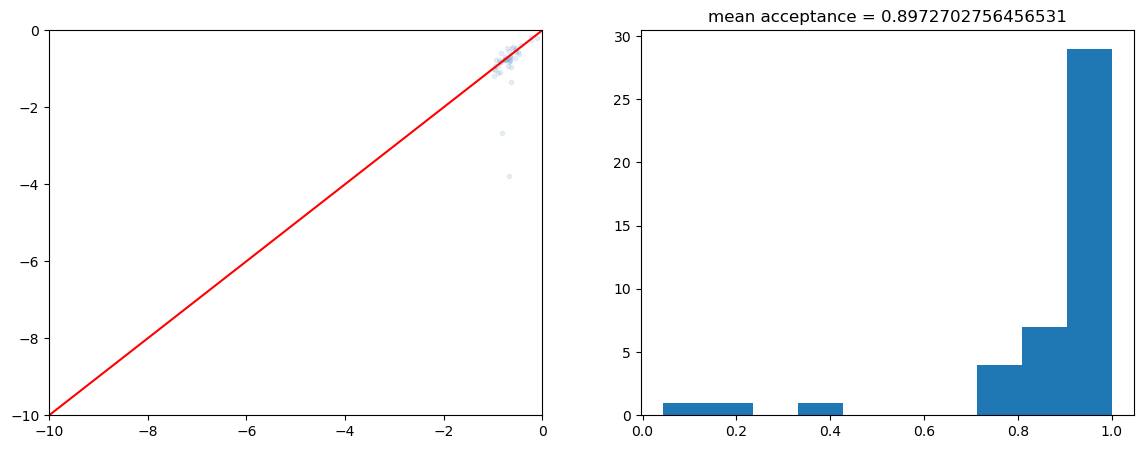

In [75]:
import surrDAMH.modules.surrogate_poly as surrogate_poly

surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=3)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], X_test)

# compute alphas and plot results
plot_results_all(res_surr)

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 3 - no poly: 165


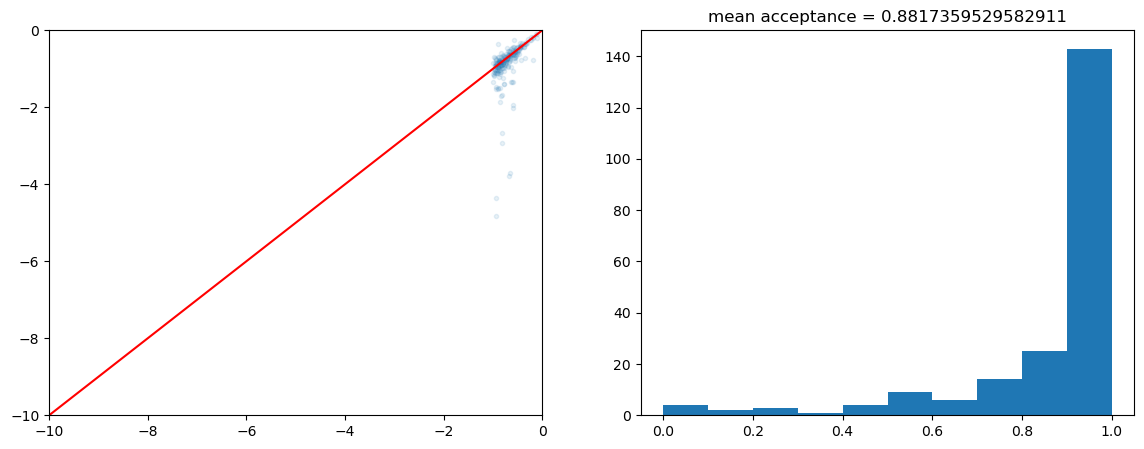

In [66]:
surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=5)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], X_test)


# compute alphas and plot results
plot_results_all(res_surr)

#### Zkouška aproximace pouze log-likelihoodu

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 5 - no poly: 1287


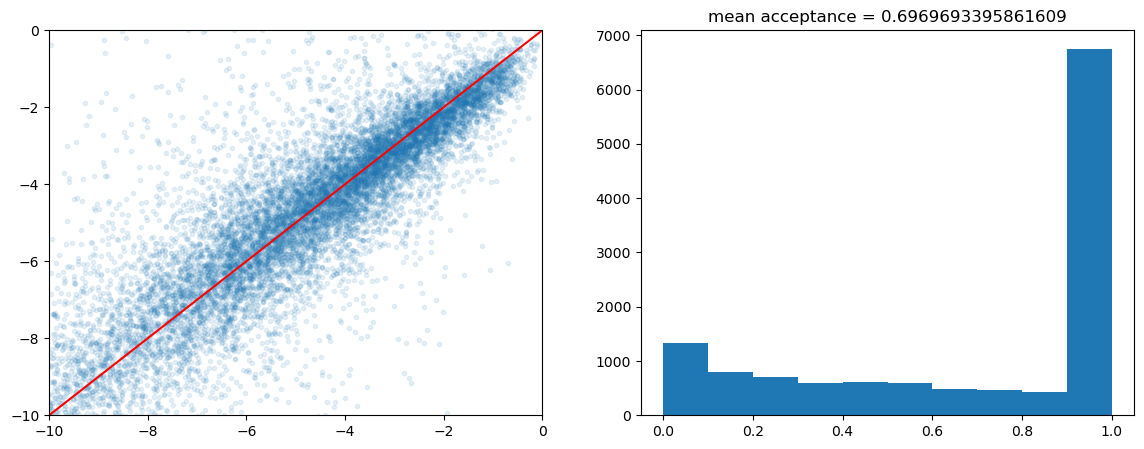

In [89]:
surr_obj = surrogate_poly.Surrogate_update(k,1,max_degree=5)
surr_obj.add_data(snapshots_likelihood)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,1)
res_surr = surr_apply_obj.apply(SOL[0], X_test)


# compute alphas and plot results
plot_results_only_likelihood(res_surr)

## Polynomial model from sklearn

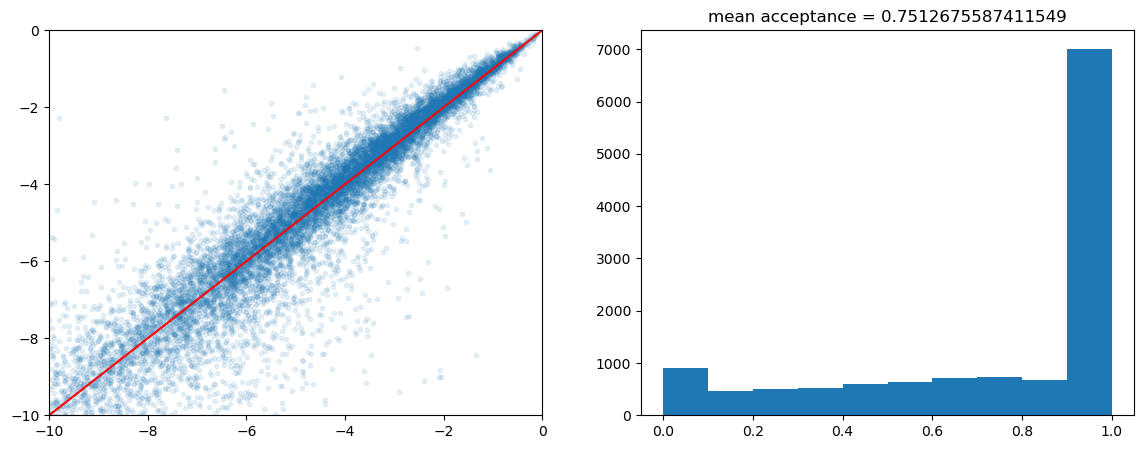

In [90]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def polynomial_regression(X, y, degree):
    # Create a pipeline that first creates polynomial features and then fits a linear regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    return model

tmp = polynomial_regression(X_train, y_train,5)
res_surr_filt = tmp.predict(parameters_transformed_filt)
res_surr = tmp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)


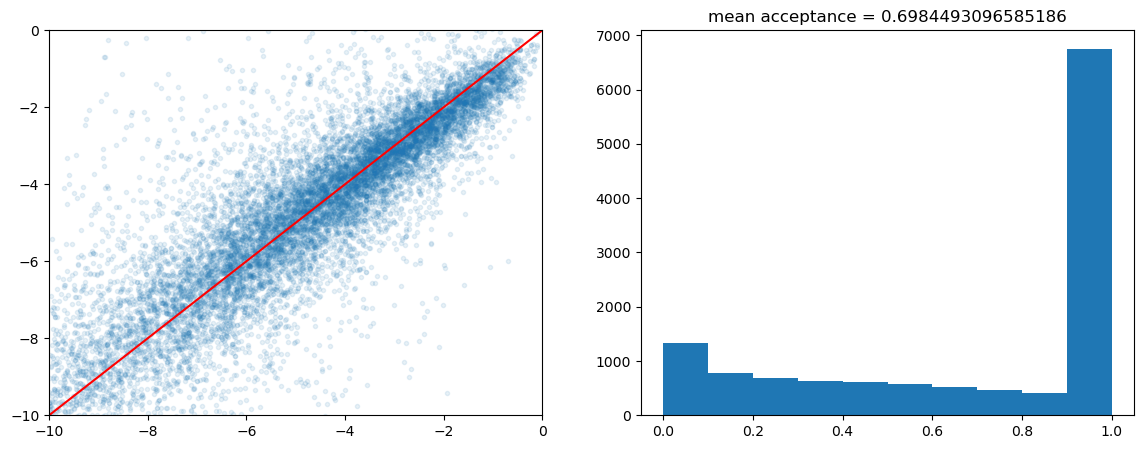

In [91]:
tmp = polynomial_regression(X_train, likelihood_train,5)
res_surr_filt = tmp.predict(parameters_transformed_filt)
res_surr = tmp.predict(X_test)

# compute alphas and plot results
plot_results_only_likelihood(res_surr)


# RBF model

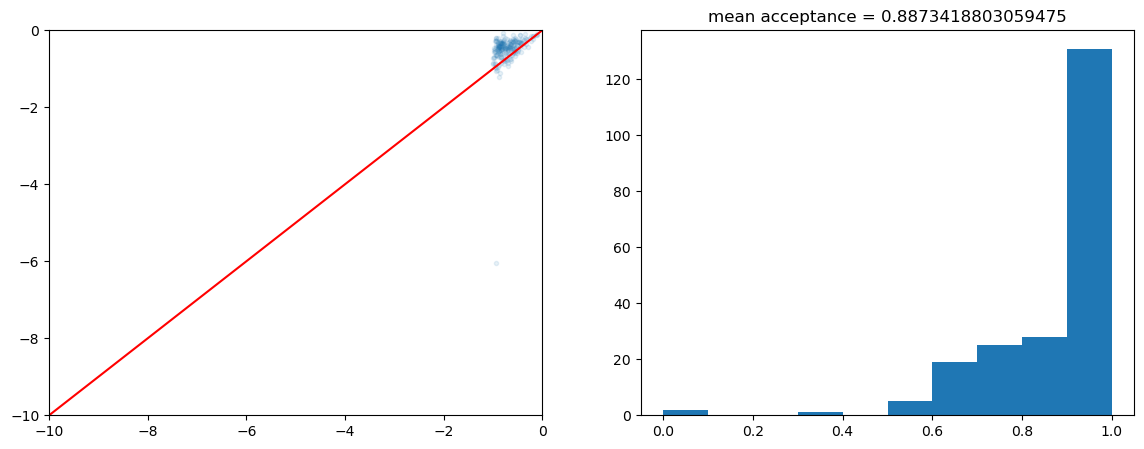

In [67]:
from surrDAMH.modules import surrogate_rbf
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=m, 
                                          initial_iteration=None, no_keep=None, expensive=False, 
                                          kernel_type=0, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,m,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], X_test)

# compute alphas and plot results
plot_results_all(res_surr)

### test only approximate log-likelihood

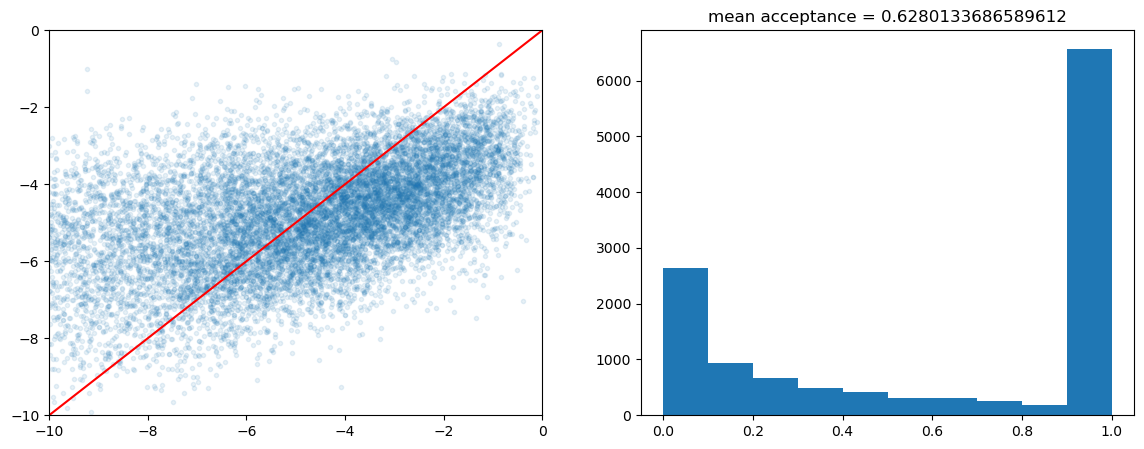

In [94]:
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=1, 
                                          initial_iteration=None, no_keep=None, expensive=False, 
                                          kernel_type=0, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots_likelihood)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,1,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], X_test)

# compute alphas and plot results
plot_results_only_likelihood(res_surr)

## RBF pomocí scipy

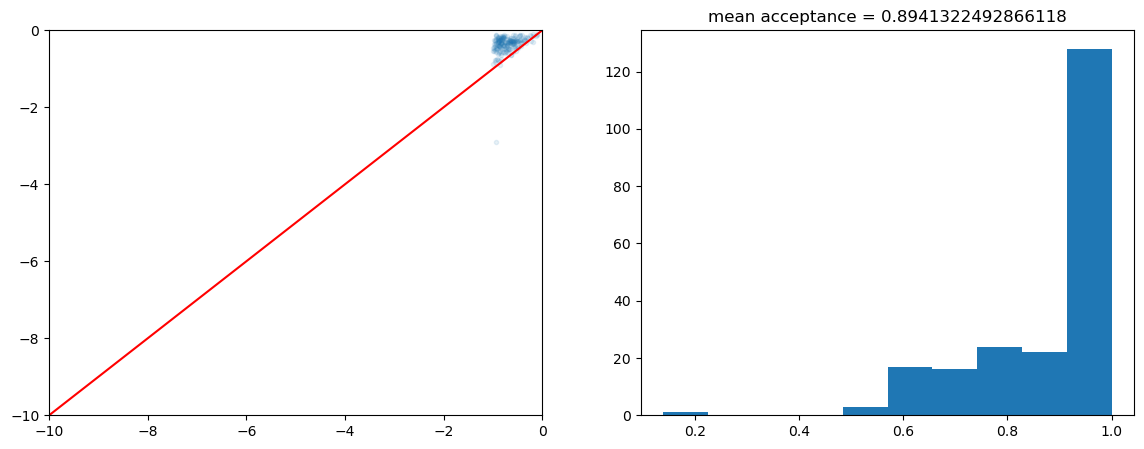

In [68]:
from scipy.interpolate import RBFInterpolator

# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""
tmp = RBFInterpolator(X_train, y_train, kernel='linear')
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

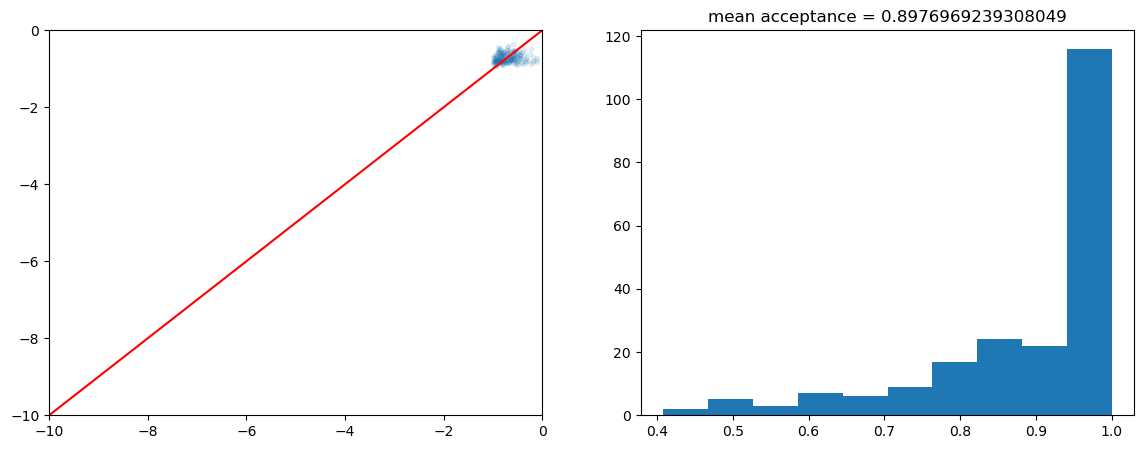

In [69]:
# aproximace pouze likelihood
tmp = RBFInterpolator(X_train, likelihood_train, kernel='linear')
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_only_likelihood(res_surr)

## více typů RBF v scipy
obdobná implementace, ale scipy je rychlejší

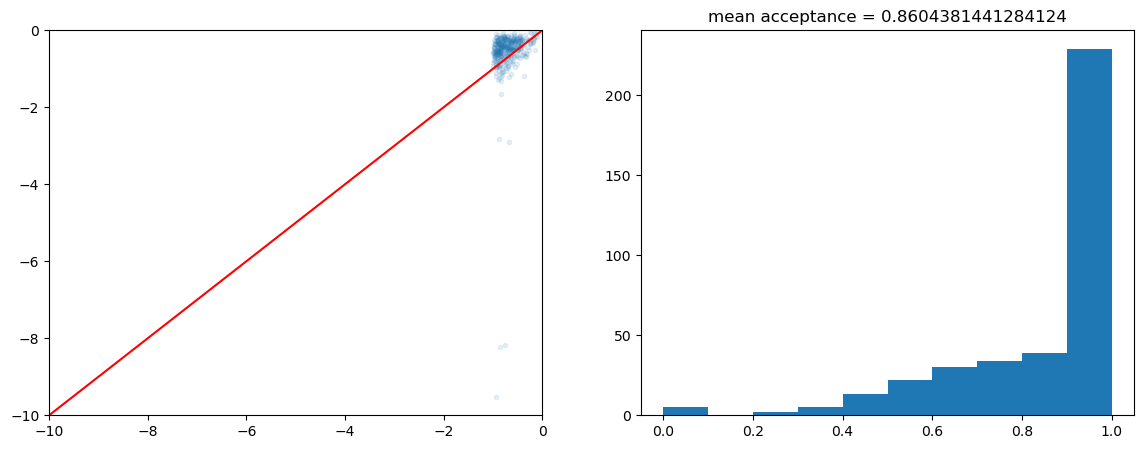

In [87]:
# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""

tmp = RBFInterpolator(X_train, y_train, kernel='linear',degree=1, epsilon=1)
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

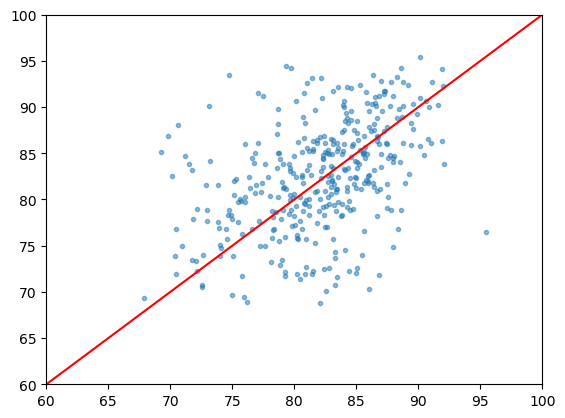

In [88]:

i = 24

plt.scatter(res_surr[:,i], y_test[:,i], alpha=0.5, marker='.')
plt.plot([60,100],[60,100], color='red')
plt.ylim(60,100)
plt.xlim(60,100)
plt.show()

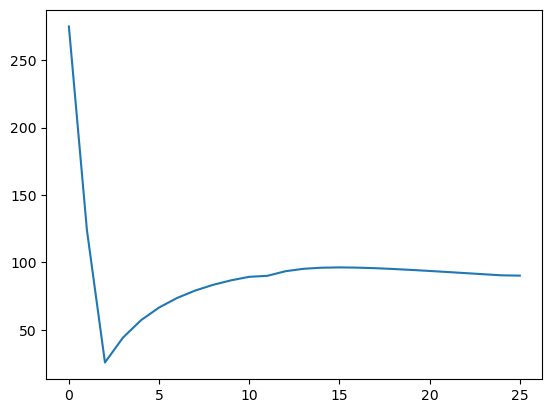

In [48]:
plt.plot(res_surr[136,0:26])

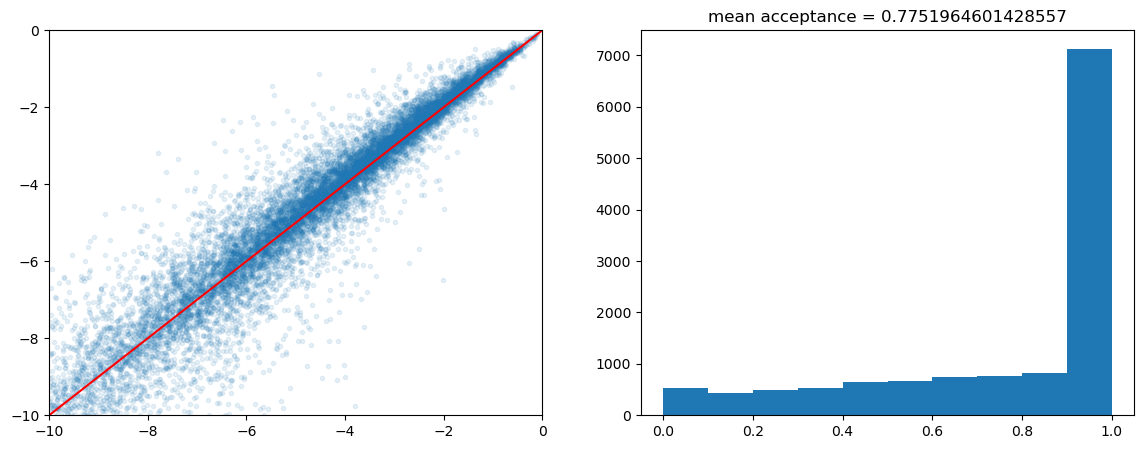

In [153]:
# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""

tmp = RBFInterpolator(X_train, y_train, kernel='thin_plate_spline',degree=4, epsilon=1)
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

# Zkouška pomocí neural network v sklearn

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7830     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90990D+03    |proj g|=  2.74794D+02


 This problem is unconstrained.



At iterate    1    f=  3.72232D+03    |proj g|=  2.68270D+02

At iterate    2    f=  2.17963D+03    |proj g|=  1.51431D+03

At iterate    3    f=  1.49097D+02    |proj g|=  3.84442D+02

At iterate    4    f=  1.41277D+02    |proj g|=  1.47827D+02

At iterate    5    f=  1.35574D+02    |proj g|=  4.52701D+01

At iterate    6    f=  1.34744D+02    |proj g|=  3.39215D+01

At iterate    7    f=  1.34190D+02    |proj g|=  3.16483D+01

At iterate    8    f=  1.32970D+02    |proj g|=  2.66442D+01

At iterate    9    f=  1.31665D+02    |proj g|=  2.90077D+01

At iterate   10    f=  1.30928D+02    |proj g|=  5.69531D+01

At iterate   11    f=  1.30230D+02    |proj g|=  2.14827D+01

At iterate   12    f=  1.29799D+02    |proj g|=  1.03537D+01

At iterate   13    f=  1.29290D+02    |proj g|=  1.76920D+01

At iterate   14    f=  1.27985D+02    |proj g|=  3.05140D+01

At iterate   15    f=  1.25705D+02    |proj g|=  2.35730D+01

At iterate   16    f=  1.20432D+02    |proj g|=  2.81892D+01

At iter

/usr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate13474    f=  1.76922D+00    |proj g|=  1.26836D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7830  13474  15001      1     0     0   1.268D+00   1.769D+00
  F =   1.7692153612672090     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


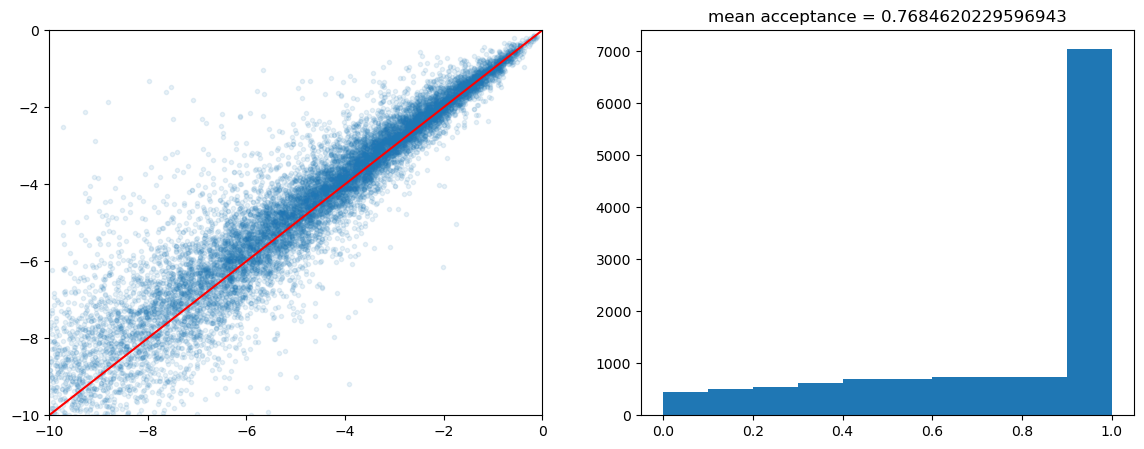

In [20]:
from sklearn.neural_network import MLPRegressor

# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(200,),activation='tanh', solver='lbfgs', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 3881.04526965
Iteration 2, loss = 3802.32966087
Iteration 3, loss = 3664.25812122
Iteration 4, loss = 3449.12632192
Iteration 5, loss = 3164.24175081
Iteration 6, loss = 2832.12017929
Iteration 7, loss = 2485.63138130
Iteration 8, loss = 2153.31376376
Iteration 9, loss = 1853.91010972
Iteration 10, loss = 1600.69359693
Iteration 11, loss = 1390.62853468
Iteration 12, loss = 1221.31191377
Iteration 13, loss = 1084.94012411
Iteration 14, loss = 975.50434492
Iteration 15, loss = 885.99809463
Iteration 16, loss = 811.51235481
Iteration 17, loss = 748.85347425
Iteration 18, loss = 694.24084297
Iteration 19, loss = 646.18849211
Iteration 20, loss = 603.05052882
Iteration 21, loss = 564.08279317
Iteration 22, loss = 528.33811394
Iteration 23, loss = 495.84376858
Iteration 24, loss = 465.99210555
Iteration 25, loss = 438.45220213
Iteration 26, loss = 413.19359189
Iteration 27, loss = 389.87215530
Iteration 28, loss = 368.50464082
Iteration 29, loss = 348.87958973
Iteration 

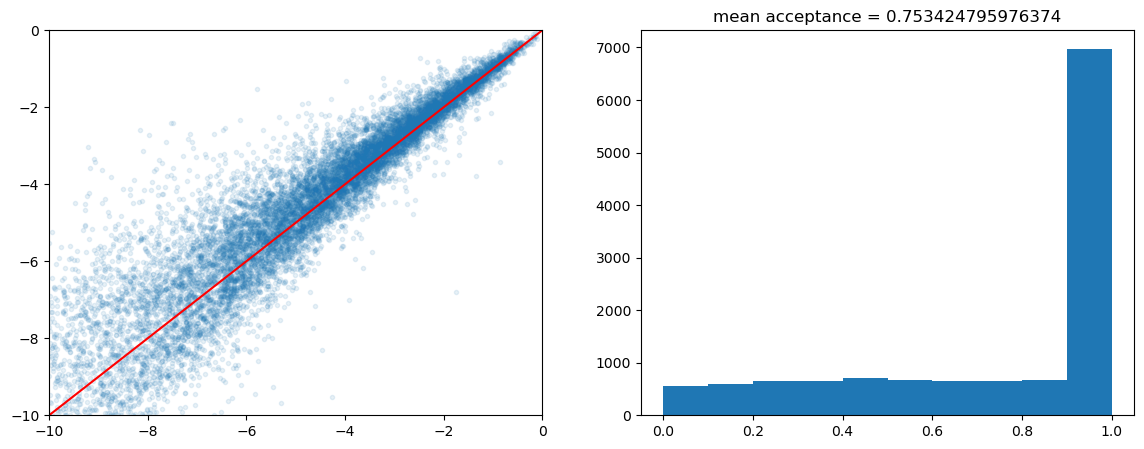

In [38]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(500,),activation='tanh', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 10.97587954
Iteration 2, loss = 8.36310949
Iteration 3, loss = 6.34846209
Iteration 4, loss = 4.89266452
Iteration 5, loss = 3.96671726
Iteration 6, loss = 3.40939137
Iteration 7, loss = 3.09718654
Iteration 8, loss = 2.91927756
Iteration 9, loss = 2.82158113
Iteration 10, loss = 2.76145407
Iteration 11, loss = 2.72022596
Iteration 12, loss = 2.68894517
Iteration 13, loss = 2.66117446
Iteration 14, loss = 2.63717982
Iteration 15, loss = 2.61638436
Iteration 16, loss = 2.59668983
Iteration 17, loss = 2.58051480
Iteration 18, loss = 2.56598238
Iteration 19, loss = 2.55308453
Iteration 20, loss = 2.54175464
Iteration 21, loss = 2.53277905
Iteration 22, loss = 2.52421369
Iteration 23, loss = 2.51778731
Iteration 24, loss = 2.51180700
Iteration 25, loss = 2.50673186
Iteration 26, loss = 2.50292293
Iteration 27, loss = 2.49975770
Iteration 28, loss = 2.49691643
Iteration 29, loss = 2.49466136
Iteration 30, loss = 2.49278977
Iteration 31, loss = 2.49111126
Iteration 32, lo

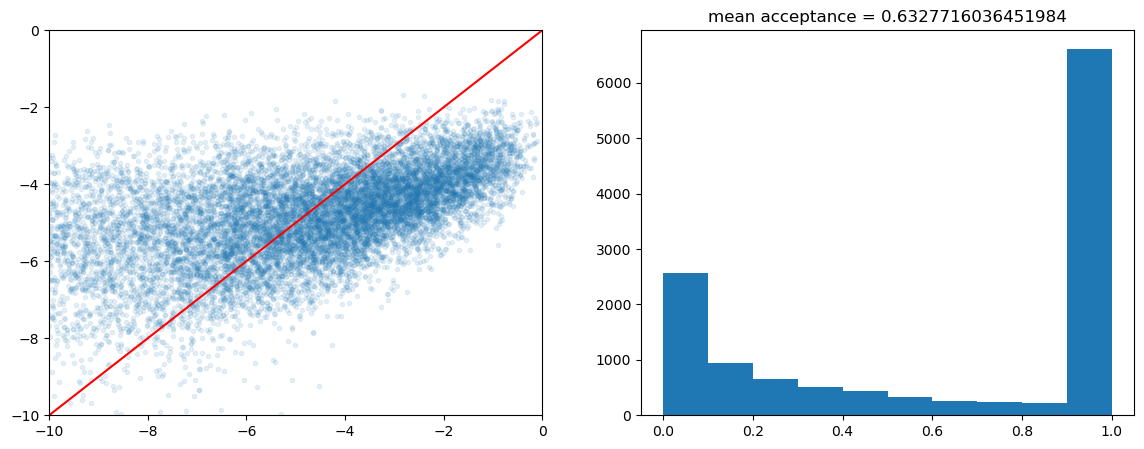

In [37]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(100,),activation='tanh', solver='adam', max_iter=5000, verbose=True)

# trénovat model
mlp.fit(X_train, likelihood_train.ravel())


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_only_likelihood(res_surr.reshape(-1,1))